# Custom transformers
- github colab : https://homl.info/colab3

In [1]:
import matplotlib
import matplotlib.pyplot
import numpy
import pathlib
import pandas
import sklearn
import sklearn.base
import sklearn.compose
import sklearn.cluster
import sklearn.impute
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics.pairwise
import sklearn.preprocessing
import sklearn.utils.validation
import tarfile
import urllib

def ch2_load_housing_data():
    tarball_path = pathlib.Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        pathlib.Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pandas.read_csv(pathlib.Path("datasets/housing/housing.csv"))

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)
    
def stratified_sampling_income_category(input_dataframe):
    input_dataframe = input_dataframe.copy()
    input_dataframe["income_cat"] = pandas.cut(input_dataframe["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., numpy.inf],
                               labels=[1, 2, 3, 4, 5])
    s_train, s_test = sklearn.model_selection.train_test_split(input_dataframe, test_size = 0.2, stratify = input_dataframe['income_cat'], random_state = 42)
    s_train.drop('income_cat', axis=1, inplace=True)
    s_test.drop('income_cat', axis=1, inplace=True)
    
    return s_train, s_test
    
# 저장할 디렉토리 설정
output_dir = pathlib.Path() / "images" / "end_to_end_project"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

input_dataframe = ch2_load_housing_data()
train, test = stratified_sampling_income_category(input_dataframe)

label = train['median_house_value'].copy()
predictor = train.drop('median_house_value', axis = 1)

imputer = sklearn.impute.SimpleImputer(strategy='median')
predictor_numtype = predictor.select_dtypes(include=[numpy.number])
imputer.fit(predictor_numtype)
X = imputer.transform(predictor_numtype)
predictor_numtype = pandas.DataFrame(X, columns = predictor_numtype.columns, index = predictor_numtype.index)

predictor_category = predictor[['ocean_proximity']]
onehot = sklearn.preprocessing.OneHotEncoder()
predictor_category_1hot = onehot.fit_transform(predictor_category)

output_dir : images\end_to_end_project


### FunctionTransformer를 이용해서 변환하고 inverse_transform 해보기 예제

<AxesSubplot: >

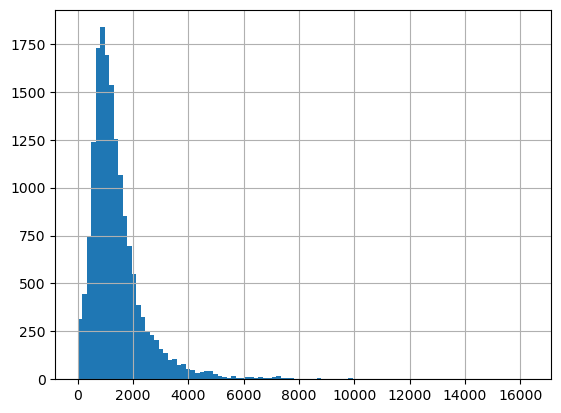

In [2]:
predictor_numtype['population'].hist(bins=100)

array([[<AxesSubplot: title={'center': 'population'}>]], dtype=object)

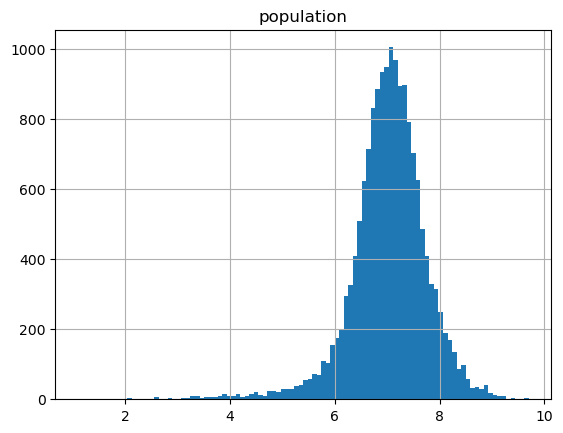

In [3]:
log_transformer = sklearn.preprocessing.FunctionTransformer(numpy.log, inverse_func = numpy.exp)
log_pop = log_transformer.transform(predictor_numtype['population'])

log_pop_dataframe = pandas.DataFrame(log_pop, columns=['population'], index=predictor_numtype.index)
log_pop_dataframe.hist(bins=100)

array([[<AxesSubplot: title={'center': 'population'}>]], dtype=object)

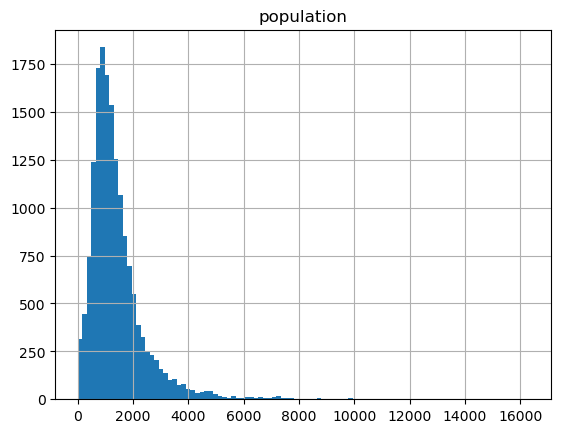

In [4]:
log_pop_inverse = log_transformer.inverse_transform(log_pop)
log_pop_inverse_dataframe = pandas.DataFrame(log_pop_inverse, columns=['population'], index=predictor_numtype.index)
log_pop_inverse_dataframe.hist(bins=100)

In [5]:
# Note that there’s no inverse function for the RBF kernel, 
# since there are always two values at a given distance from a fixed point (except at distance 0)

rbf_transformer = sklearn.preprocessing.FunctionTransformer(sklearn.metrics.pairwise.rbf_kernel,
                                      kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(predictor_numtype[["housing_median_age"]])
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

In [6]:
# If you pass it an array with two features, it will measure 
# the 2D distance (Euclidean) to measure similarity
sf_coords = 37.7749, -122.41
sf_transformer = sklearn.preprocessing.FunctionTransformer(sklearn.metrics.pairwise.rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(predictor_numtype[["latitude", "longitude"]])
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

In [7]:
# X[:, [i]] = select ith column
ratio_transformer = sklearn.preprocessing.FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(numpy.array([[1., 2.], [3., 4.]]))

array([[0.5 ],
       [0.75]])

# Custom class 구현을 통해 Scikit-Learn pipeline에 사용할 수 있는 Custom transformer 구현해 보기
- Scikit-Learn Transformer는 duck typing에 의존하기 때문에 transformer가 fit과 transform만 지원해 주면 붙여서 쓸 수 있다 
- TransformerMixin 을 상속하면 fit_transform()을 따로 구현하지 않아도 따라온다
- BaseEstimator를 상속하면 get_params()와 set_params()가 따라온다. 단, 이러려면 constructor에서 `*args`와 `**kwargs`를 사용해서는 안된다

In [8]:
class StandardScalerClone(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, with_mean=True):# no *args or **kwargs!
        self.with_mean = with_mean

    def fit(self, X, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

In [9]:
# 참고로 DataFrame의 shape은 이렇게 생겼음 : (num row, num col)
input_dataframe.shape

(20640, 10)

### 책에 나와 있는 Custom transformer 관련 노트 (이건 나중에 짤때 알고 짜야 할 것 같아서 남김)
- The sklearn.utils.validation package contains several functions we can use to validate the inputs. For simplicity, we will skip such tests in the rest of this book, but production code should have them.
- Scikit-Learn pipelines require the fit() method to have two arguments X and y, which is why we need the y=None argument even though we don’t use y.
- All Scikit-Learn estimators set n_features_in_ in the fit() method, and they ensure that the data passed to transform() or predict() has this number of features.
- The fit() method must return self.
- This implementation is not 100% complete: all estimators should set feature_names_in_ in the fit() method when they are passed a DataFrame. Moreover, all transformers should provide a get_feature_names_out() method, as well as an inverse_transform() method when their transformation can be reversed. See the last exercise at the end of this chapter for more details

In [10]:
class ClusterSimilarity(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = sklearn.cluster.KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return sklearn.metrics.pairwise.rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [11]:
cluster_simil_transformer = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
cluster_simil = cluster_simil_transformer.fit_transform(predictor_numtype[['latitude','longitude']], sample_weight=label)

C:\Users\ctint\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
cluster_simil[:3].round(2)

array([[0.  , 0.14, 0.  , 0.  , 0.  , 0.08, 0.  , 0.99, 0.  , 0.6 ],
       [0.63, 0.  , 0.99, 0.  , 0.  , 0.  , 0.04, 0.  , 0.11, 0.  ],
       [0.  , 0.29, 0.  , 0.  , 0.01, 0.44, 0.  , 0.7 , 0.  , 0.3 ]])

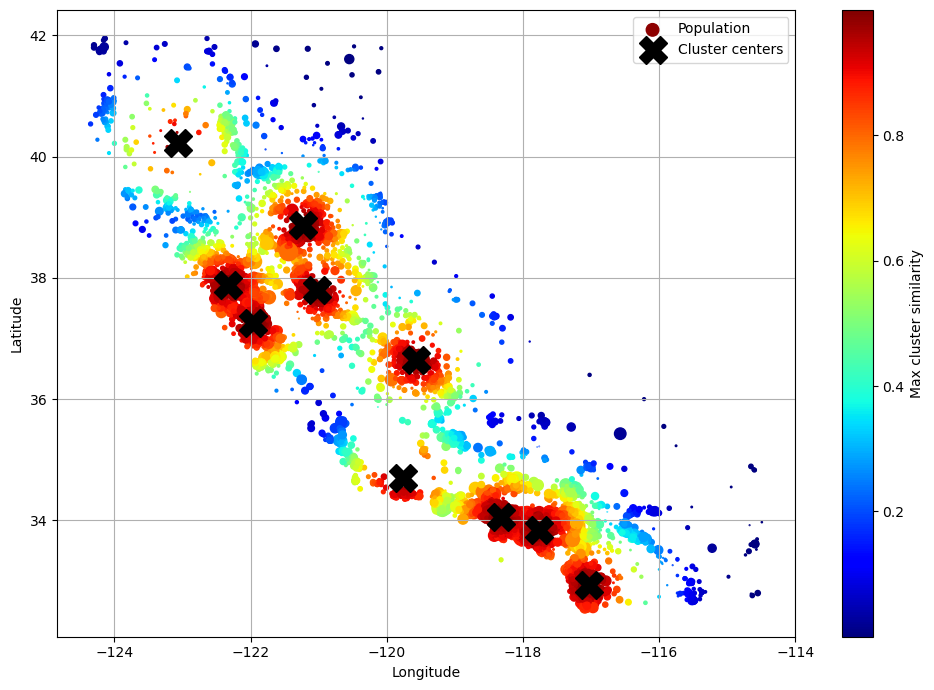

In [13]:
prednum_ren = predictor_numtype.rename(columns = {
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"
})

# 이렇게 해서 가장 similarity가 높은거 하나만 쓴다. 오오... 근데 다 쓰는게 더 낫지 않을까 싶기도
prednum_ren['Max cluster similarity'] = cluster_simil.max(axis=1) 
prednum_ren.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=prednum_ren["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))
matplotlib.pyplot.plot(cluster_simil_transformer.kmeans_.cluster_centers_[:, 1],
         cluster_simil_transformer.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
matplotlib.pyplot.legend(loc='upper right')
matplotlib_to_imagefile(output_dir, 'district_cluster_plot')
matplotlib.pyplot.show()

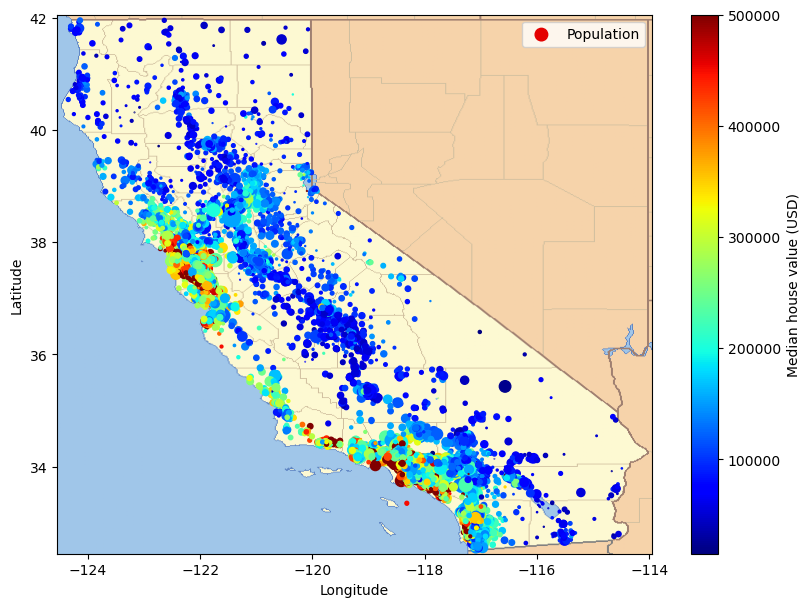

In [14]:
#
# 참고로 이게 실제 가격 지도
# 위에것만 보면 꽤 그럴듯 하지만 실제 가격을 보면 좀 차이가 있다는 걸 알 수 있다
# 내 생각에는 억지로라도 숫자 맞춰 cluster찾아내는 K-means보다는 단순하게 KNN으로 estimate하는게 제일 그럴듯할 것 같은데... 
#

filename = "california.png"
if not (output_dir / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, output_dir / filename)
    
train_ren = train.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (USD)"})

train_ren.plot(
             kind="scatter", x="Longitude", y="Latitude",
             s=train_ren["Population"] / 100, label="Population",
             c="Median house value (USD)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

california_img = matplotlib.pyplot.imread(output_dir / filename)

axis = -124.55, -113.95, 32.45, 42.05
matplotlib.pyplot.axis(axis)

matplotlib.pyplot.imshow(california_img, extent=axis)

matplotlib.pyplot.show()